In [1]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from torchvision.ops import FeaturePyramidNetwork
from utils.clip import load_clip
import einops
import torch.nn as nn
import torch.nn.functional as F
from utils.layers import RelativeCrossAttentionModule
from models.conditional_unet1d import ConditionalUnet1D
from utils.position_encodings import SinusoidalPosEmb
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from utils.position_encodings import RotaryPositionEncoding, RotaryPositionEncoding3D, RotaryPositionEncoding2D
from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt


/home/felix/miniforge3/envs/tshape/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PushTDataset(torch.utils.data.Dataset):
    def __init__(self, rgb, goal_mask, tee_mask, agent_mask, agent_pos, goal_pose):
        self.rgb = rgb
        self.target = goal_mask
        self.tee_mask = tee_mask
        self.agent_mask = agent_mask
        self.agent_pos = agent_pos
        self.goal_pose = goal_pose

    def __getitem__(self, index):
        item = {}
        item['rgb'] = self.rgb[index]
        item['goal_mask'] = self.target[index]
        item['tee_mask'] = self.tee_mask[index]
        item['agent_mask'] = self.agent_mask[index]
        item['agent_pos'] = self.agent_pos[index]
        item['goal_pose'] = self.goal_pose[index]
        return item

    def __len__(self):
        return len(self.rgb)


def get_loader(data_dir='../data/'):
    files = os.listdir(data_dir)
    files = [f for f in files if f.endswith('.npz')]

    rgb = []
    goal_mask = []
    tee_mask = []
    agent_mask = []
    agent_pos = []
    goal_pose = []

    for f in files:
        el = np.load(data_dir + f)
        rgb.append(el['image'])
        goal_mask.append(el['goal_mask'])
        tee_mask.append(el['tee_mask'])
        agent_mask.append(el['agent_mask'])
        agent_pos.append(el['agent_pos'])
        goal_pose.append(el['goal_pose'])

    rgb = np.stack(rgb, axis=0)
    goal_mask = np.stack(goal_mask, axis=0)
    tee_mask = np.stack(tee_mask, axis=0)
    agent_mask = np.stack(agent_mask, axis=0)
    agent_pos = np.stack(agent_pos, axis=0)
    goal_pose = np.stack(goal_pose, axis=0)

    rgb = torch.from_numpy(rgb).float()
    goal_mask = torch.from_numpy(goal_mask).float()
    tee_mask = torch.from_numpy(tee_mask).float()
    agent_mask = torch.from_numpy(agent_mask).float()
    agent_pos = torch.from_numpy(agent_pos).float()
    goal_pose = torch.from_numpy(goal_pose).float()
    
    dataset = PushTDataset(rgb, goal_mask, tee_mask, agent_mask, agent_pos, goal_pose)

    return torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [3]:
train_loader = get_loader()

item = next(iter(train_loader))

print("item['rgb'].shape", item['rgb'].shape)
print("item['goal_mask'].shape", item['goal_mask'].shape)
print("item['tee_mask'].shape", item['tee_mask'].shape)
print("item['agent_mask'].shape", item['agent_mask'].shape)
print("item['agent_pos'].shape", item['agent_pos'].shape)
print("item['goal_pose'].shape", item['goal_pose'].shape)


item['rgb'].shape torch.Size([10, 3, 96, 96])
item['goal_mask'].shape torch.Size([10, 96, 96])
item['tee_mask'].shape torch.Size([10, 96, 96])
item['agent_mask'].shape torch.Size([10, 96, 96])
item['agent_pos'].shape torch.Size([10, 2])
item['goal_pose'].shape torch.Size([10, 3])


In [4]:
def compute_visual_features(model, linear, images, out_res=[24, 24]):
    with torch.no_grad():
        if out_res == [24, 24]:
            img_features = model(images)["res2"]
        elif out_res == [48, 48]:
            img_features = model(images)["res1"]
        else:
            raise NotImplementedError
    hw = img_features.shape[-2:]

    img_features = einops.rearrange(img_features, 'b c h w -> b (h w) c')
    img_features = linear(img_features)
    img_features = einops.rearrange(img_features, 'b (h w) c -> b c h w', h=hw[0], w=hw[1])

    img_features = F.interpolate(img_features, size=out_res, mode='bilinear', align_corners=False)
    return img_features


In [5]:
def compute_scene_features(vis_features, positions, query_embedding, query_position, rotary_embedder, re_cross_attn):
    batch_size = vis_features.shape[0]
    target_sequence_length = query_position.shape[1]
    query = query_embedding.weight.unsqueeze(1).repeat(target_sequence_length, batch_size, 1)
    query_rel_pe = rotary_embedder(query_position)

    value = einops.rearrange(vis_features, 'b c h w -> (h w) b c')
    value_pos = positions
    value_pos = einops.rearrange(value_pos, 'b c h w -> b (w h) c')
    value_rel_pe = rotary_embedder(value_pos)

    scene_embedding = re_cross_attn(query=query, value=value, query_pos=query_rel_pe, value_pos=value_rel_pe)
    return scene_embedding[-1]

In [11]:
class FILM(nn.Module):

    def __init__(self, in_channels, cond_channels, hidden_channels=512, diffusion_step_embed_dim=256):
        super().__init__()
        self.in_channels = in_channels
        self.cond_channels = cond_channels
        dsed = diffusion_step_embed_dim

        self.input_encoder = nn.Linear(in_channels, hidden_channels)
        self.cond_encoder = nn.Linear(cond_channels + dsed, 2*hidden_channels)

        self.hidden_input_encoder = nn.ModuleList([
            nn.Linear(in_channels, hidden_channels),
            nn.Linear(hidden_channels, hidden_channels),
            nn.Linear(hidden_channels, hidden_channels),
        ]
        )
        self.hidden_cond_encoder = nn.ModuleList([
            nn.Linear(cond_channels + dsed, 2*hidden_channels),
            nn.Linear(cond_channels + dsed, 2*hidden_channels),
            nn.Linear(cond_channels + dsed, 2*hidden_channels),
        ]
        )

        self.out_proj = nn.Linear(hidden_channels, in_channels)
        self.act = nn.ReLU()
        self.diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )



    def forward(self, sample, timestep, global_cond):
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        timesteps = timestep.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)

        global_feature = torch.cat([
            global_feature, global_cond
        ], axis=-1)

        out = sample
        for input_encoder, cond_encoder in zip(self.hidden_input_encoder, self.hidden_cond_encoder):
            out = self.act(input_encoder(out))
            scale, bias = self.act(cond_encoder(global_feature)).chunk(2, dim=-1)
            out = out * scale + bias


        # out = self.act(self.input_encoder(sample))
        # scale, bias = self.act(self.cond_encoder(global_feature)).chunk(2, dim=-1)
        # out = out * scale + bias
        out = self.out_proj(out)


        return out

In [7]:
class DenoisingMLP(nn.Module):

    def __init__(self, in_channels, cond_channels, hidden_channels=128, diffusion_step_embed_dim=256):
        super().__init__()
        self.in_channels = in_channels
        self.cond_channels = cond_channels
        dsed = diffusion_step_embed_dim

        self.seq = nn.Sequential(
            nn.Linear(in_channels + cond_channels + dsed, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, in_channels),

        )

        self.diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )

    def forward(self, sample, timestep, global_cond):
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        timesteps = timestep.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)
        
        global_feature = torch.cat([
            global_feature, global_cond
        ], axis=-1)

        out = torch.cat([
            sample, global_feature
        ], axis=-1)

        out = self.seq(out)
        return out

In [8]:
def get_positions(shape):
    xy = torch.meshgrid([torch.linspace(0, 1, shape[0]), torch.linspace(0, 1, shape[1])])
    xy = torch.stack(xy, dim=0).float()
    return xy

In [14]:
from models.ema_model import EMAModel
from diffusers.optimization import get_scheduler

num_epochs = 10000
embedding_dim = 60
action_dim = 2
num_noised_samples = 64
device = torch.device('cuda')

vis_backbone, normalize = load_clip()
vis_out_proj = nn.Linear(256, embedding_dim).to(device)
re_cross_attn = RelativeCrossAttentionModule(embedding_dim=embedding_dim, num_attn_heads=3, num_layers=4).to(device)
query_embedding = nn.Embedding(1, embedding_dim).to(device)
rotary_embedder = RotaryPositionEncoding2D(embedding_dim).to(device)

noise_pred_net = FILM(
    in_channels=action_dim,  
    cond_channels=embedding_dim,
    hidden_channels=512,
    diffusion_step_embed_dim=256
)


nets = nn.ModuleDict({
    'vision_encoder': vis_backbone,
    'vision_proj': vis_out_proj,
    'noise_pred_net': noise_pred_net,
    'query_embedding': query_embedding,
    're_cross_attn': re_cross_attn,
})

ema_nets = copy.deepcopy(nets)
_ = nets.to(device)
_ = ema_nets.to(device)
ema = EMAModel(ema_nets)

num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

optimizer = torch.optim.AdamW(
    params=nets.parameters(),
    lr=1e-4, weight_decay=1e-6)

lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_loader) * num_epochs
)

def normalize_position(x):
    return x / 512.

def unnormalize_position(x):
    return x * 512.

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    losses = list()
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(train_loader, desc='Batch', leave=False) as tepoch:
            for item in tepoch:
                rgb = normalize(item['rgb'].to(device))
                agent_pos = normalize_position(item['agent_pos']).to(device)
                goal_pos = normalize_position(item['goal_pose'][..., :2]).to(device)

                B = rgb.shape[0]

                rel_goal_pos = goal_pos - agent_pos
                rel_goal_pos = einops.repeat(rel_goal_pos, 'b c -> (nns b) c', nns=num_noised_samples)

                noise = torch.randn(rel_goal_pos.shape).to(device)

                rgb_features = compute_visual_features(nets["vision_encoder"], nets["vision_proj"], rgb, out_res=[24, 24])
                rgb_pos = get_positions(rgb_features.shape[-2:]).to(device)
                rgb_pos = einops.repeat(rgb_pos, 'c h w -> (nns b) (h w) c', nns=num_noised_samples, b=B)
                
                rgb_features = einops.repeat(rgb_features, 'b c h w -> (h w) (nns b) c', nns=num_noised_samples)
                query_pos = einops.repeat(agent_pos, 'b c -> (nns b) 1 c', nns=num_noised_samples)

                target_sequence_length = 1
                query = einops.repeat(query_embedding.weight, '1 c -> 1 (nns b) c', nns=num_noised_samples, b=B)
                query_pos = rotary_embedder(query_pos)

                context_features = rgb_features
                context_pos = rotary_embedder(rgb_pos)

                scene_embedding = re_cross_attn(query=query, value=context_features, query_pos=query_pos, value_pos=context_pos)
                scene_embedding = scene_embedding[-1].squeeze(0)

                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (B*num_noised_samples,), device=device
                        ).long()

                noisy_actions = noise_scheduler.add_noise(
                    rel_goal_pos, noise, timesteps)

                noise_pred = nets["noise_pred_net"](sample=noisy_actions, timestep=timesteps, global_cond=scene_embedding)
                loss = nn.functional.mse_loss(noise_pred, noise)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(nets)

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
        epoch_loss = np.mean(epoch_loss)
        losses.append(epoch_loss)
        tglobal.set_postfix(loss=epoch_loss)

ema_nets = ema.averaged_model

Epoch:  43%|████▎     | 4302/10000 [04:35<06:04, 15.61it/s, loss=0.00012] 


KeyboardInterrupt: 

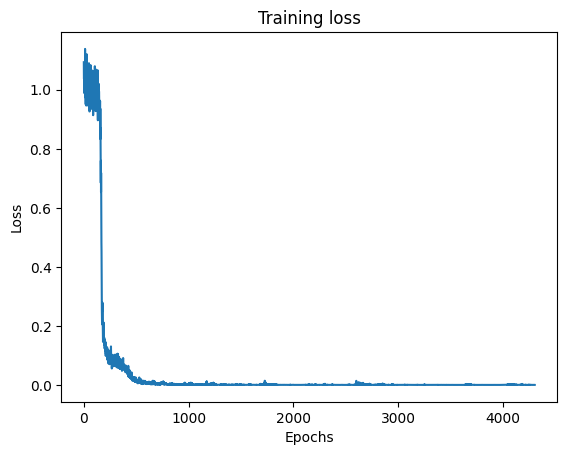

In [15]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

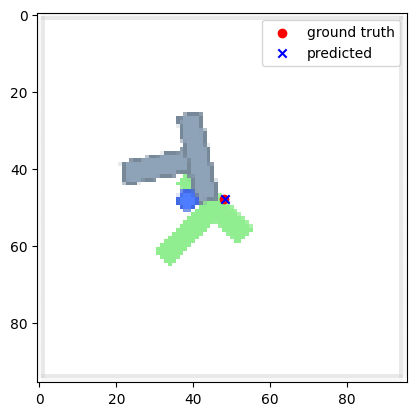

In [77]:
ema_nets = ema.averaged_model
item = next(iter(train_loader))
rgb = normalize(item['rgb'][:1].to(device))
agent_pos = normalize_position(item['agent_pos'][:1]).to(device)
goal_pos = normalize_position(item['goal_pose'][..., :2][:1]).to(device)

B = rgb.shape[0]

rgb_features = compute_visual_features(nets["vision_encoder"], nets["vision_proj"], rgb, out_res=[24, 24])
rgb_pos = get_positions(rgb_features.shape[-2:]).to(device)
rgb_pos = einops.repeat(rgb_pos, 'c h w -> b (h w) c', b=B)

rgb_features = einops.rearrange(rgb_features, 'b c h w -> (h w) b c')
query_pos = einops.rearrange(agent_pos, 'b c -> b 1 c')

target_sequence_length = 1
query = einops.repeat(query_embedding.weight, '1 c -> 1 b c', b=B)
query_pos = rotary_embedder(query_pos)

context_features = rgb_features
context_pos = rotary_embedder(rgb_pos)

scene_embedding = nets["re_cross_attn"](query=query, value=context_features, query_pos=query_pos, value_pos=context_pos)
scene_embedding = scene_embedding[-1].squeeze(0)

noisy_action = torch.randn(
    (B, action_dim), device=device)
naction = noisy_action

noise_scheduler.set_timesteps(num_inference_steps=num_diffusion_iters, device=device)

with torch.no_grad():
    for k in noise_scheduler.timesteps:
        noise_pred = ema_nets['noise_pred_net'](
                            sample=naction,
                            timestep=k,
                            global_cond=scene_embedding
                        )
                        # inverse diffusion step (remove noise)
        naction = noise_scheduler.step(
            model_output=noise_pred,
            timestep=k,
            sample=naction
        ).prev_sample

naction = unnormalize_position(naction.cpu())[0]
goal_pos_pred_image = (naction + item['agent_pos'][0]) / 512. * 96.
goal_pos_image = item['goal_pose'][0] / 512. * 96.
plt.imshow(item['rgb'][0].permute(1, 2, 0).cpu().numpy())
plt.scatter(goal_pos_image[0], goal_pos_image[1], c='r', label='ground truth')
plt.scatter(goal_pos_pred_image[0], goal_pos_pred_image[1], c='b', marker='x', label='predicted')
plt.legend()
plt.show() 